In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_iris

# Applied Machine Learning

## Classification, decision trees

### Last time

- We came to some kind of general framework: select your loss function, select your model, then optimize
- We talked about linear models
- In homework we tried it on practice

### Classification

- The naïve loss function we could choose is 1/0
- We miss if our prediction is wrong
- Everything is just perfect otherwise 
- There is a problem with that

### Geometry of classification

Let's consider two blobs

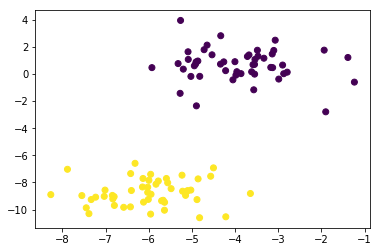

In [2]:
X, y = make_blobs(n_samples=100, centers=2, random_state=17)
plt.scatter(X[:, 0], X[:, 1], c=y);

### Geometry of classification

Let's project the data using a hyperplane

In [3]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000).fit(X, y)
xx, yy = np.meshgrid(np.linspace(-10, 0, 100), np.linspace(-15, 5, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

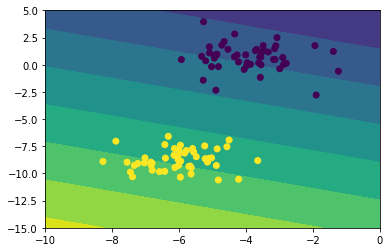

In [4]:
plt.contourf(xx, yy, Z.reshape(xx.shape));
plt.scatter(X[:, 0], X[:, 1], c=y);

### Geometry of classification

The projection makes 1/0 loss obvious

In [5]:
def project(model, data):
    return (np.dot(data, model.coef_.T) + model.intercept_).ravel()

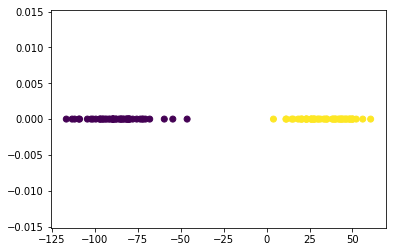

In [6]:
plt.scatter(project(clf, X), np.zeros_like(y), c=y);

### 1/0 loss

In case of positive (+1) class

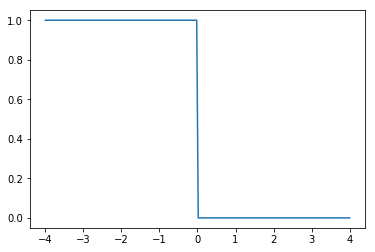

In [7]:
xs = np.linspace(-4, 4, 200); y_true = +1.0
plt.plot(xs, xs < 0.0);

### Surrogate loss

- Optimizing 1/0 is infeasible
- It is even NP-hard as it is reducible to satisfiability problem
- In simpler words: you don't know how to change the weights to make it better
- We need an approximation

### Logistic loss

The loss of `LogisticRegression`

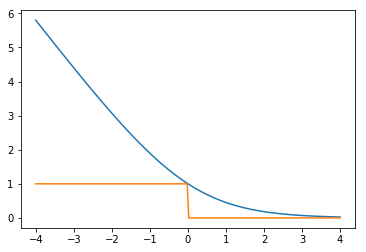

In [8]:
xs = np.linspace(-4, 4, 200); y_true = +1.0
plt.plot(xs, np.log2(1.0 + np.exp(-y_true*xs)));
plt.plot(xs, xs < 0.0);

### Hinge loss

The loss of `LinearSVC`

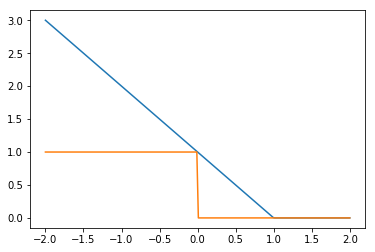

In [9]:
xs = np.linspace(-2, 2, 200); y_true = +1.0
plt.plot(xs, np.maximum(0.0, 1.0 - y_true*xs));
plt.plot(xs, xs < 0.0);

### The choice of loss

- You can't know for sure
- Logistic loss will lead to better probability estimation
- Logistic loss might have worse accuracy
- Hinge loss might have better accuracy

### Multiclass problems

- Not all the problems we have are binary
- Happily, we can reduce them to binary subproblems
- The usual strategy is One vs Rest (OvR)

### One versus Rest

- For any $K$-class problem we construct $K$ classifiers
- Each classifier $K_i$ tries to tell the $i$-th class from the rest
- To predict, we compare outputs of each classifier
- The classifier with the highest confidence wins

### Standartization

- The usual approach to standartize your features is to subtract the mean and divide by the std
- Important if regularization is used
- Useful for linear models, neural networks, and distance-based models

In [10]:
data = load_iris()['data']
data[:, 0] = (data[:, 0] - data[:, 0].mean()) / data[:, 0].std()
data[:, 0].mean(), data[:, 0].std()

(-4.736951571734001e-16, 1.0)

### Missing data handling

- Real data could have missing values
- One approach is dropping the missing data (columns/rows)
- Dropping rows is usually a bad idea
- Linear models would tolerate replacing with mean/median

### Count features

- Most counts are Poisson- or exponentially distributed
- They have 'heavy tails' model should adapt to

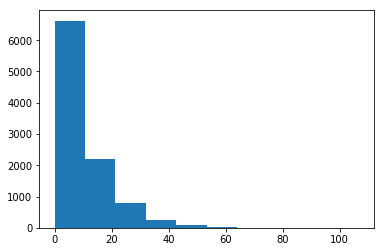

In [11]:
sample = np.random.exponential(scale=10.0, size=10000)
plt.hist(sample);

### Count features

- Counts are usually transformed using `log` or `sqrt`
- This squashes the tail

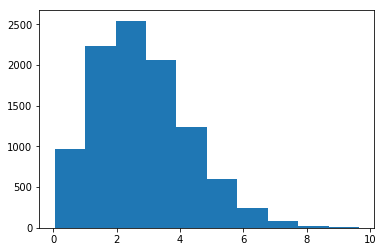

In [12]:
sample = np.random.exponential(scale=10.0, size=10000)
plt.hist(np.sqrt(sample));

### Feature engineering

- Linear models 'like' when features are gaussian-like
- Your goal is to integrate all the knowledge about the domain
- Even good model is useless on bad features

Let's check the Adult dataset

In [13]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Splitting

- One way to engineer a feature
- Does it help to work hard?
- We need a measure

In [14]:
df['hard-working'] = (df['hours-per-week'] > 45)

### Entropy

The measure of disorder, $- \sum_i p_i \log_2 p_i $

In [15]:
df['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

### Entropy

The measure of disorder, $- \sum_i p_i \log_2 p_i $

In [16]:
ps = np.array(df['income'].value_counts(normalize=True))
ps, np.log2(ps), ps * np.log2(ps)

(array([0.76071823, 0.23928177]),
 array([-0.39456591, -2.06321763]),
 array([-0.30015348, -0.49369036]))

In [17]:
- sum(ps * np.log2(ps))

0.7938438393644256

### Entropy after the split

In [18]:
ps = np.array(df[df['hard-working'] == True]['income'].value_counts(normalize=True))
- sum(ps * np.log2(ps))

0.9795613770348133

In [19]:
ps = np.array(df[df['hard-working'] == False]['income'].value_counts(normalize=True))
- sum(ps * np.log2(ps))

0.7008243647538459

### Information gain

- The difference between entropies tells us something
- We had some entropy before the split
- We've got some entropy after the split
- The information we gain is difference between these entropies

### Decision tree

- We can split a few times
- This forms a tree of different conditions
- In the leafs of this tree we make a final decision

In [20]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('adult.csv', index_col=0)
df.fillna(inplace=True, value=-1.0)
df = df.apply(LabelEncoder().fit_transform)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(df.drop(columns='income'), df.income)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

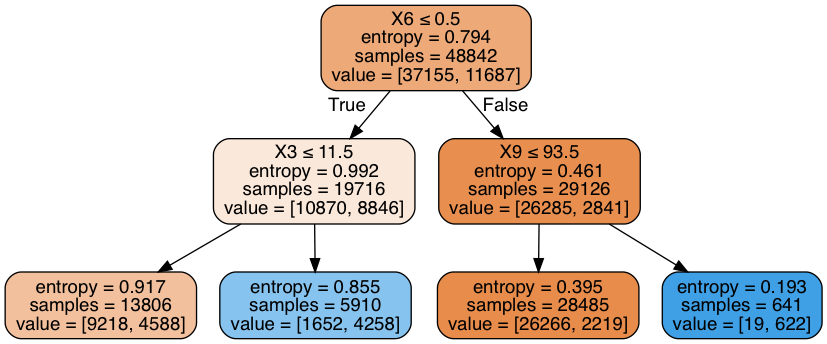

In [21]:
Image(graph.create_png())

### ID3 algorithm

One of the first algorithm to train decision trees

- Choose the split based on information gain (and do not reuse it anymore)
- Create a node with the split
- Recurse on children nodes made by the split

A greedy algorithm as the problem is NP-hard again

### Further development

Details are in:
- Splitting continuous variables
- Choosing the right split (entropy is not the only way)
- Combining a few splits at the time
- etc etc etc

This led to CART, C4.5, C5.0 and many other algorithms

### Notes

- Decision trees are quite versatile, any features are fine
- Missing data can be happily replaced by -1 (or any other non-existent value)
- No obvious loss/objective function we minimize directly

### In Python

In [22]:
from sklearn.tree import DecisionTreeClassifier
df = pd.read_csv('cs-training.csv', index_col=0)
df.fillna(inplace=True, value=-1.0)
dt = DecisionTreeClassifier()
dt.fit(df.drop(columns='SeriousDlqin2yrs'), df.SeriousDlqin2yrs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Overfitting

- Decision trees are quite prone to overfitting due to exponential nature
- Play Akinator to check you don't need many questions to guess the very concrete person
- We need to regularize them too

### Regularization, again

- The simplest measure of complexity of a tree is its depth
- Minimize error with minimal possible depth
- Other ways include limiting the minimal numbers of examples in a leaf

### Next time

- Other way to fight overfitting, ensembling models
- Boosting and bagging